# Wash Trading Detection on AMM Decentralized Exchanges

In [1]:
import pandas as pd
import math
import requests
import json
import numpy as np
import webbrowser
import time
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from web3 import Web3
from web3.middleware import geth_poa_middleware

from hexbytes import HexBytes as hb
pd.set_option('display.max_columns', 500)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2
from functions import * # most functions are kept there for convenience
bsc_scan_api_key = "ID63Y14WNZY1NTAP8DEHN28KTC4NZAVHM4" # Additional API key = "7ID9DCEPSKZM4EHW8UZE8YC4SF6CFRPRC9"
binance_provider = 'https://bsc-dataseed.binance.org' 
w3 = Web3(Web3.HTTPProvider(binance_provider))



pair_address = "0xb5d7cc509f9de98e35f054392666122fdd4def47" # token_names = {"token0": "DARK", "token1": "BUSD"}
# Information about the Pair
abi = get_bsc_contract_abi(bsc_scan_api_key, pair_address) # gets an abi for the pair contract - it is universal for pancakeswap at least
token_abi = get_bsc_contract_abi(bsc_scan_api_key, "0x55d398326f99059fF775485246999027B3197955") # gets a generic token abi to be able to read token's contract symbol
pair_info = get_pair_info(pair_address, abi, bsc_scan_api_key, w3, token_abi) # gets pair info
signatures = get_signatures_from_abi(abi) # extracts signatures of events in abi - it is universal for pancakeswap at least

pair_info["signatures"] = signatures

## Get the latest transactions in Pancake Swap from Bscscan


In [2]:
# write hours that you want to scrape
scrape_last_hours = 6
# BSC blocks are once every 3 seconds
blocks_every_n_seconds = 3

blocks_ago = scrape_last_hours * 60 * 60 // blocks_every_n_seconds
results = get_bsc_historical_pancake_swaps(fromBlock = w3.eth.blockNumber - blocks_ago, toBlock = w3.eth.blockNumber, bsc_scan_api_key = bsc_scan_api_key)

getting BSC Historical Logs from block 25608845 to block 25616045...
Found 1000 txs from 25608845 block to 25608898 block.
Found 1000 txs from 25608898 block to 25608950 block.
Found 1000 txs from 25608950 block to 25609005 block.
Found 1000 txs from 25609005 block to 25609060 block.
Found 1000 txs from 25609060 block to 25609112 block.
Found 1000 txs from 25609112 block to 25609173 block.
Found 1000 txs from 25609173 block to 25609233 block.
Found 1000 txs from 25609233 block to 25609291 block.
Found 1000 txs from 25609291 block to 25609353 block.
Found 1000 txs from 25609353 block to 25609407 block.
Found 1000 txs from 25609407 block to 25609462 block.
Found 1000 txs from 25609462 block to 25609525 block.
Found 1000 txs from 25609525 block to 25609578 block.
Found 1000 txs from 25609578 block to 25609627 block.
Found 1000 txs from 25609627 block to 25609668 block.
Found 1000 txs from 25609668 block to 25609726 block.
Found 1000 txs from 25609726 block to 25609781 block.
Found 1000 tx

## Crude analysis and filtering of addresses 

In [3]:
df = pd.DataFrame(results) # turn the list of dictionary to pandas dataframe
df = parse_results_dataframe(df, pair_info) # parse the tx info 

swapping_contracts = list(set(df.contract_address)) + [
    "0x10ed43c718714eb63d5aa57b78b54704e256024e", # PancakeSwap: Router v2 contract address 
    "0x000000000000000000000000000000000000dead" # null address for token burning
] 

df = df[~df['To'].isin(swapping_contracts)] # drop swaps that contain these addresses as to. Only can contain (and will contain) as 'from' for simple swaps

hour_window = (df.timeStamp.max() - df.timeStamp.min()) / (60 * 60)
print(f"Table contains {len(df)} txs from {df.DateTime.min()} to {df.DateTime.max()}, which is {round(hour_window, 2)} hour window")

# Crude analysis of every address: txs_from_address, percent_txs_from_address
all_swaps=df[df.event == "Swap"]

total_token1_volume_by_all_addresses = (all_swaps["amount1In"].sum() + all_swaps["amount1Out"].sum())
total_token0_volume_by_all_addresses = (all_swaps["amount0In"].sum() + all_swaps["amount0Out"].sum())
# Select a treshold of swaps that need to be made by any single address to stay in dataframe
all_swaps = keep_active_adresses(all_swaps = all_swaps, at_least_swaps = 5) # rapidly filters out the majority of adresses that had very few swaps

# get percent fraction of txs made by this address compared to all txs
all_swappers = set(all_swaps.dropna(subset = ["To"]).To.to_list())
all_swappers.discard(pair_address)
all_swappers.discard("0x0000000000000000000000000000000000000000")
iteration = 0

analyzed_swaps = pd.DataFrame()

for address in list(all_swappers):

    address_swaps = all_swaps[(all_swaps.To == address)].copy()
    if len(address_swaps)<4:
        continue
    iteration += 1

    print(f"Analysing address {iteration} out of {len(list(all_swappers))}", end = "\r")

    address_swaps["txs_from_address"] = len(address_swaps)
    address_swaps["percent_txs_from_address"] = round((len(address_swaps) / len(all_swaps) * 100), 4)

    # find most active pair
    most_common_pair_address = max(set(address_swaps.contract_address.to_list()), key = address_swaps.contract_address.to_list().count) 
    address_swaps["most_common_pair_address"] = most_common_pair_address
    address_swaps["focused_on_single_pair"] = (len(set(address_swaps.contract_address.to_list())) == 1)

    # measure volume
    total_amount1Out_by_address = sum(address_swaps["amount1Out"])
    total_amount1In_by_address = sum(address_swaps["amount1In"])
    address_swaps["total_amount1Out_by_address"] = total_amount1Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount1In_by_address"] = total_amount1In_by_address
    address_swaps["total_token1_volume_by_address"] = total_amount1Out_by_address + total_amount1In_by_address

    total_amount0Out_by_address = sum(address_swaps["amount0Out"])
    total_amount0In_by_address = sum(address_swaps["amount0In"])
    address_swaps["total_amount0Out_by_address"] = total_amount0Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount0In_by_address"] = total_amount0In_by_address
    address_swaps["total_token0_volume_by_address"] = total_amount0Out_by_address + total_amount0In_by_address

    # measure percent fraction of volume: (total address volume) / (total volume by all addresses) * 100
    address_swaps["percent_token1_volume_by_address"] = (total_amount1Out_by_address + total_amount1In_by_address) / total_token1_volume_by_all_addresses * 100
    address_swaps["percent_token0_volume_by_address"] = (total_amount0Out_by_address + total_amount0In_by_address) / total_token0_volume_by_all_addresses * 100
    
    # here filter out the most common pair address and continue the analysis
    address_swaps = address_swaps[address_swaps.contract_address == most_common_pair_address] 

    # count how many txs appear in same block
    address_swaps["txs_in_same_block"] = address_swaps.drop_duplicates("transactionHash").duplicated(subset = ["contract_address", "blockNumber"]).sum()

    # quantify if address is mostly buying, selling or both. Quantify the position in terms of buy/sell ratio 
    position_ratio = (address_swaps.amount0In.sum() + address_swaps.amount1Out.sum() + 1) / (address_swaps.amount1In.sum() + address_swaps.amount0Out.sum() + 1)
    if position_ratio < 1:
        position_ratio = 1/position_ratio
    address_swaps["position_ratio"] = position_ratio

    # many bad market makers use same amounts of tokens for trades - quantify the similarity of these amounts to indicate crappy bot - 0 if no simmilarity, 1 if maximum similarity
    token0_ammount_similarity = 1 - (len(set(address_swaps.amount0Out + address_swaps.amount0In)) / len(address_swaps)) # 1 / (fraction unique)
    token1_ammount_similarity = 1 - (len(set(address_swaps.amount1Out + address_swaps.amount1In)) / len(address_swaps)) # 1 / (fraction unique)
    tx_size_similarity = max(token0_ammount_similarity, token1_ammount_similarity) # chose the larger one
    address_swaps["tx_size_similarity"] = tx_size_similarity

    # get token price, which is simply a ratio of the Swap
    token0_price_in_token1 = pd.to_numeric((address_swaps.amount1In + address_swaps.amount1Out) / (address_swaps.amount0In + address_swaps.amount0Out)) #* (10**(pair_info["token0_decimals"]-pair_info["token1_decimals"])) # accounting for token decimals shown in contract
    token1_price_in_token0 = 1 / token0_price_in_token1
    # get current accumulated position
    position_token0 = (address_swaps.amount0Out.sum() - address_swaps.amount0In.sum()) #* 10**-pair_info["token0_decimals"]
    position_token1 = (address_swaps.amount1Out.sum()  - address_swaps.amount1In.sum()) #* 10**-pair_info["token1_decimals"]
    # get profits in terms of token0 and token1 
    address_position_token0 = position_token0 + (position_token1 * token1_price_in_token0.iloc[-1]) # token1_price_in_token0 is series - take only last item!
    address_position_token1 = position_token1 + (position_token0 * token0_price_in_token1.iloc[-1])
    address_swaps['profit_in_token0'] = address_position_token0
    address_swaps['profit_in_token1'] = address_position_token1

    # put to dataframe
    analyzed_swaps = pd.concat([analyzed_swaps, address_swaps[[
        "percent_txs_from_address", 
        "txs_from_address", 
        "txs_in_same_block", 
        "position_ratio", 
        "tx_size_similarity", 
        "focused_on_single_pair", 
        "most_common_pair_address", 
        "profit_in_token0", 
        "profit_in_token1"
    ]]])

df = all_swaps

display(df.head())
# 17.3 s for 3833 adresses

Throwing out 0 txs
Table contains 64193 txs from 2023-02-12 17:21:31 to 2023-02-12 23:24:34, which is 6.05 hour window


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out
28893,0x486489b4bf0f03634eaf6e030df279a8d64a0cb8,0x00000000000000000000000000000000000000000000...,25610499,0x5a8c848ef226b0240b583b881255723522a7e4af97e4...,1676227478,5000000000,288262,337,0x26e7de4707ea1192e018d54960351f3c783e2a541454...,170,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x0000000000000000000000000000000000000001,2023-02-12 18:44:38,0,10247716010141188667427,1460742345767053976562,0
67598,0x486489b4bf0f03634eaf6e030df279a8d64a0cb8,0x00000000000000000000000000000000000000000000...,25613174,0x2a921606bde4862384db8fdf6ea92c157d78cb1a12d1...,1676235588,5000000000,288262,42,0xe5d5669e77cfcbc15b63217bc2117812f7f7e3f77bff...,6,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x0000000000000000000000000000000000000001,2023-02-12 20:59:48,0,10183747863774901234986,1459248899306896685554,0
98353,0x486489b4bf0f03634eaf6e030df279a8d64a0cb8,0x00000000000000000000000000000000000000000000...,25615555,0xaa72b7c6cd526972ce955a8cd70c613daae3436afdc2...,1676242791,5000000000,271978,163,0x9a6b07b62b761d461fc8edbde3deaca771c9dcca47be...,50,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x0000000000000000000000000000000000000001,2023-02-12 22:59:51,0,10130056955276993266043,1452728618767016967398,0
71380,0x486489b4bf0f03634eaf6e030df279a8d64a0cb8,0x00000000000000000000000000000000000000000000...,25613462,0xd8c33e54461a31f43ece34faa8eac8ae66925359f52f...,1676236489,5000000000,288262,250,0x472f56a62c955106cd0322bdb40499fe740f26055659...,111,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x0000000000000000000000000000000000000001,2023-02-12 21:14:49,0,10173564115911126333751,1455972718021826766593,0
46902,0x486489b4bf0f03634eaf6e030df279a8d64a0cb8,0x00000000000000000000000000000000000000000000...,25611697,0x0b5dc24256d8b268b258fa9291c531ac44525c1edbf1...,1676231082,5000000000,288262,156,0xa713ad23b66321433d184b05ee32a3bf1b6af19c9fb6...,39,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x0000000000000000000000000000000000000001,2023-02-12 19:44:42,0,10206786591416068435334,1446245271080351071248,0


## Analyzing pair contracts and checking for wash trading activity

The number of unique pair contract addresses that were active during the 6 hour window: 1197
BUSD price in MBP
The shape of wash traded transactions' dataframe: (53, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 1.1975459316349801
The number of accounts that commited wash trading: 4


,Wash Traders
0,0x018b80c13684c481f72f09ac817a43bf1d3b776d
1,0x0b9e4c3298ec58a6655d06e2727733de87516e9f
2,0xf4e6ab2ef6b593eb3d995b9c90b416d294de3152
3,0xfac3e21ec7f380510e2161560680645c196a438c


https://bscscan.com/address/0x74d8578456560f33aff5eaca8f472126b5c0fb3c#tokentxns


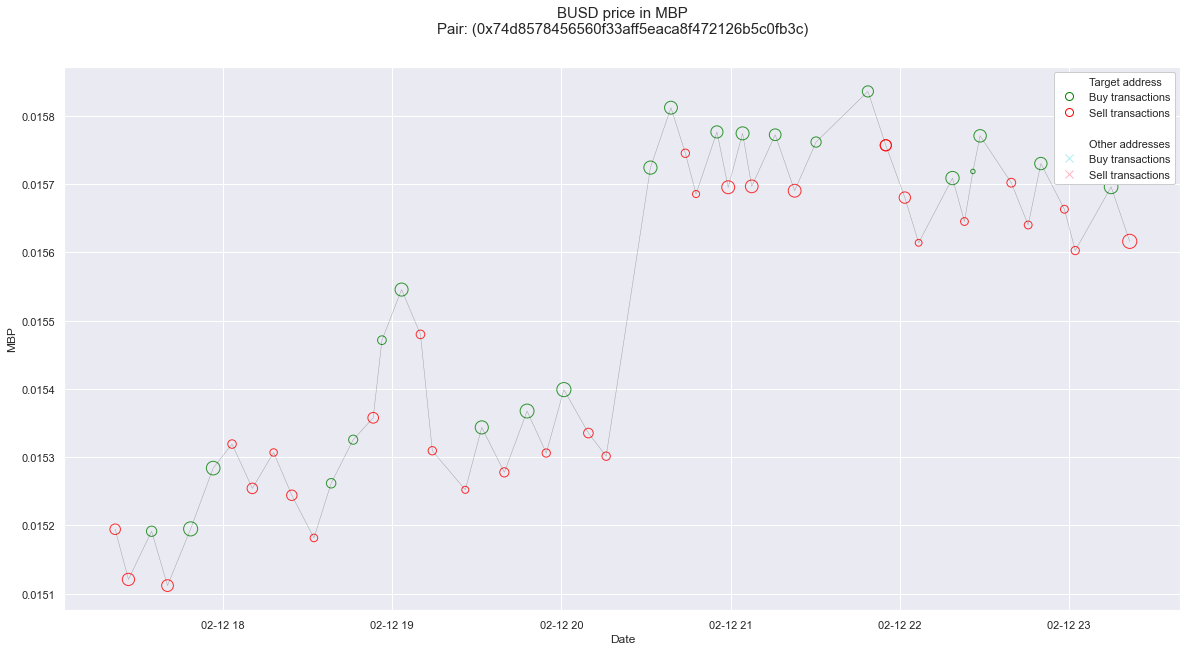

BUSD price in HI
The shape of wash traded transactions' dataframe: (76, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 0.8911801612643678
The number of accounts that commited wash trading: 10


,Wash Traders
0,0x03cfe3ee1924d9fc0e5215a71f5ba6f2903ef733
1,0x1409d881797158abc4830265ea852bafd6f41421
2,0x19f0966e32c136996aa9e694fcc0add0f84d4dde
3,0x1d1ac07b915022d5f4e0f34aa19739423cd2e860
4,0x44378f25a462cc5de3ff85a7445d1c94a1df480d
5,0x5071af5b78ca0809ee4abfeb3894b23ba6276682
6,0x9a71905450cdb6c0dd1a36f17e973d271e216e13
7,0xb5b38283786ac8791398112e88cbec5a524846d2
8,0xcc2a3606080d8fbf13660164dba740e99252c79f
9,0xf8abdf124c9c7b2b3b012c3422507df03a25debb


https://bscscan.com/address/0x7d9a46ac9cb22a6c4e6a94253c309c0551f717fe#tokentxns


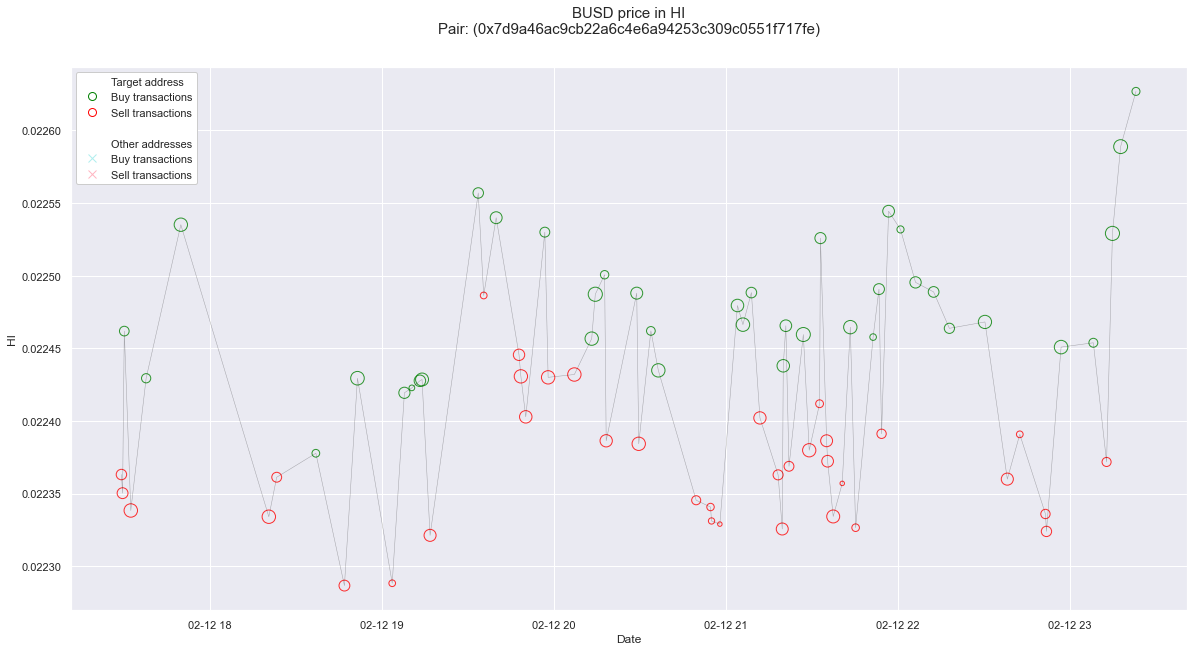

WBNB price in PEN
The shape of wash traded transactions' dataframe: (51, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 0.99851011101061
The number of accounts that commited wash trading: 2


,Wash Traders
0,0x07a8ee876eef8f3cb28bedefc850d2752ffb85e9
1,0xcadd75ca627f58afdd0c1dc04bf9a7ac465b586c


https://bscscan.com/address/0x82003890b719df9bf2c07aaf38f5b6fc5a3d0000#tokentxns


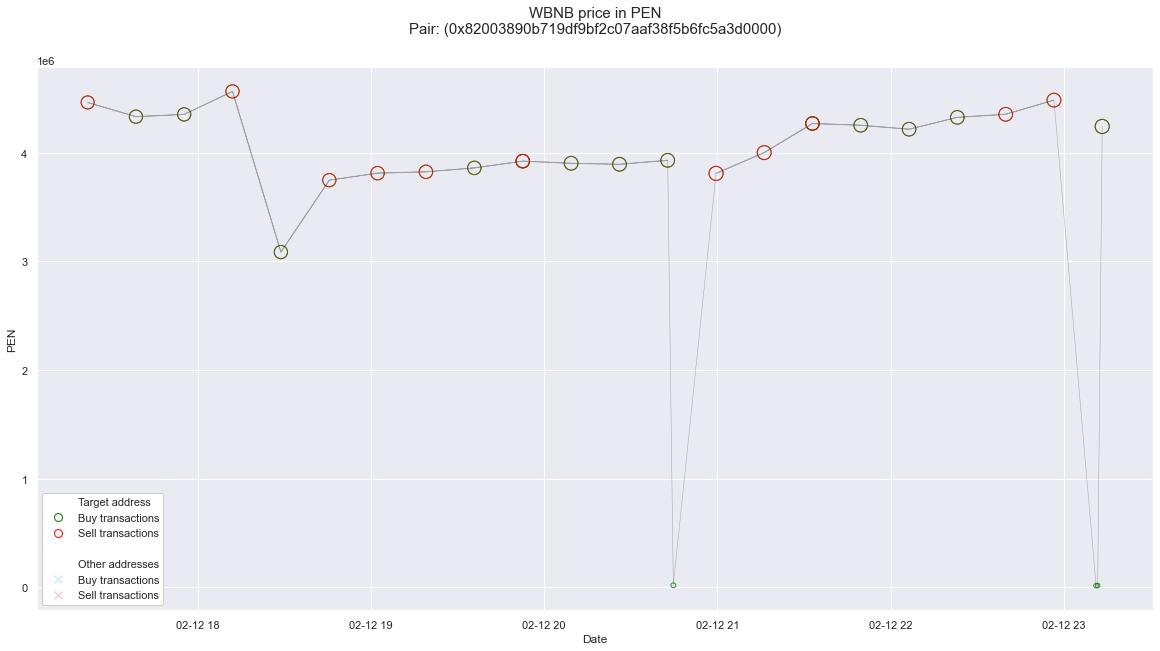

GQ price in BUSD
The shape of wash traded transactions' dataframe: (55, 22).
The shape of other transactions' dataframe: (5, 22).
The percentage of volume traded in this specific pair contract address: 64.96 %
The position ratio: 1.0198285130601112
The number of accounts that commited wash trading: 19


,Wash Traders
0,0x09a3bf35590488f178e2fa0ce855b10db28cd64c
1,0x0b34fe6847c8c151db5d60781b093bdb2e96c48d
2,0x0e7306cb9c01708778533396fae9d311d3bdcc65
3,0x2135bf3ec89b8fd182d087f9a3f00dcc1e4a8228
4,0x324ec7743a70212299ae82ad674f7547e6b4069d
5,0x34cf45f0097989109889c588ea2f4c08668a4a2d
6,0x3747eba039d945371bd73a16d17a43cba7f4a0d2
7,0x38bebea4ad6cf659d8df7eb9ffd30df8ae0931a5
8,0x38e21aad71e5f20c7937ab022a01f497bcbc2dea
9,0x4f91e50566120e53309dff2e0c3fcbe36e2f3a4a


https://bscscan.com/address/0x72121d60b0e2f01c0fb7fe32ca24021b42165a40#tokentxns


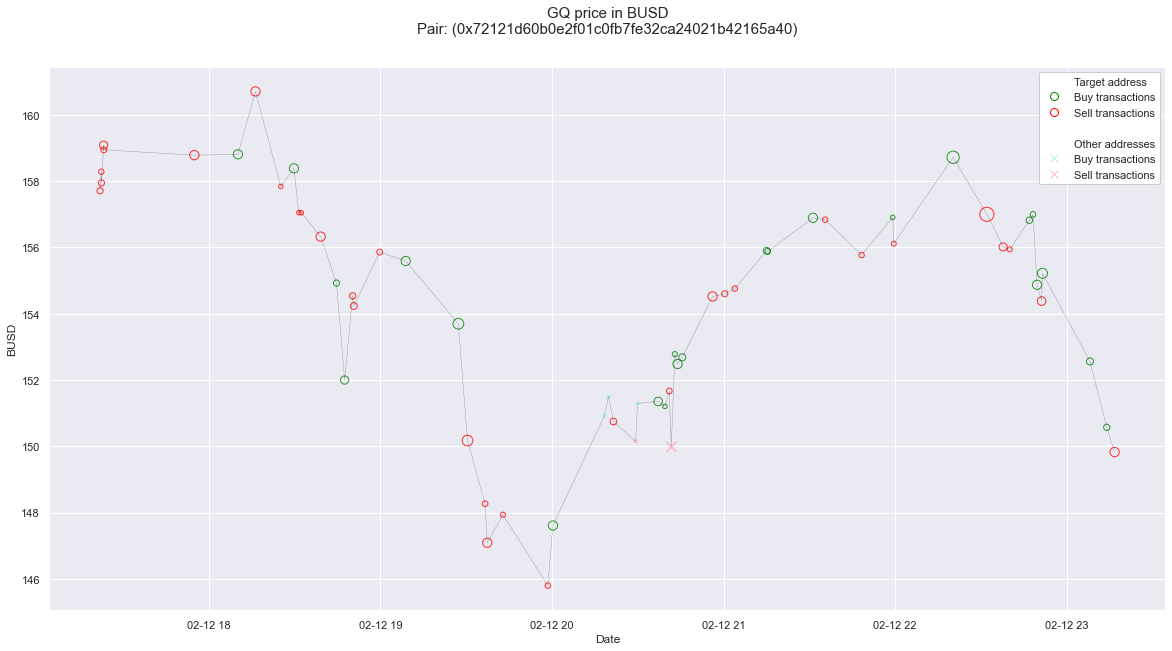

WBNB price in EMP
The shape of wash traded transactions' dataframe: (166, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 1.0011813946340669
The number of accounts that commited wash trading: 8


,Wash Traders
0,0x0b34fe6847c8c151db5d60781b093bdb2e96c48d
1,0x879bfe8ec2ac980d20909bef327019c8f65b9e94
2,0x935f71230502a9eff8a87070166a0b235ba02c1a
3,0x948892e5615a4b10532f57f61cc60f3eb8c8b706
4,0xa06cbfbc8618c79ea14522ace7f71b8b4ce16869
5,0xba00491661d1036ce7f9cb6a1a804a015c342820
6,0xd15d2d06ef3b0d76f3aaa245f844f73849d99d08
7,0xf805c1239bdef769f4b08b91ca372155a0baca4f


https://bscscan.com/address/0xeb87e567147d529ae5b17b88422d25b8670a67a1#tokentxns


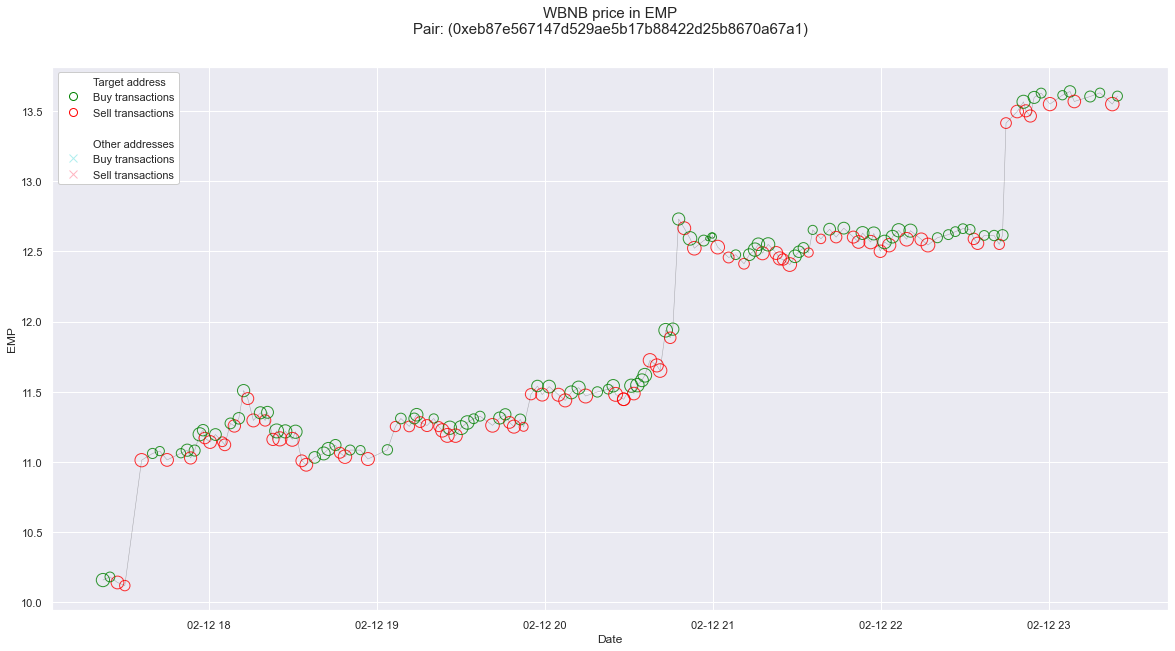

BUSD price in ULX
The shape of wash traded transactions' dataframe: (43, 22).
The shape of other transactions' dataframe: (15, 22).
The percentage of volume traded in this specific pair contract address: 72.17 %
The position ratio: 0.8701150997211434
The number of accounts that commited wash trading: 8


,Wash Traders
0,0x0c725ad6527d9730c2b839216aa81963ba6b3030
1,0x10131f700e8c275a628ce714b4ae54371ffe603d
2,0x10ba0086e36ddd2311f5d2484c9eb47c1019269d
3,0x427ab7d5f1c6c67e4ed23db9d094d87aba4fee75
4,0xa662a2470f5cf01fb72c75bf998275fa15b727c6
5,0xc2e44cc68925903290b53ed2f297d0eb4ea6a5ac
6,0xd98d21383f0f7865cf64e1f2b8018ffe635b66a0
7,0xea64fc05457816230e7f4015a97c8db7a1d8a8d1


https://bscscan.com/address/0x65f2ee8b6c52a263b39f1ffc8f97d4b38f14e96d#tokentxns


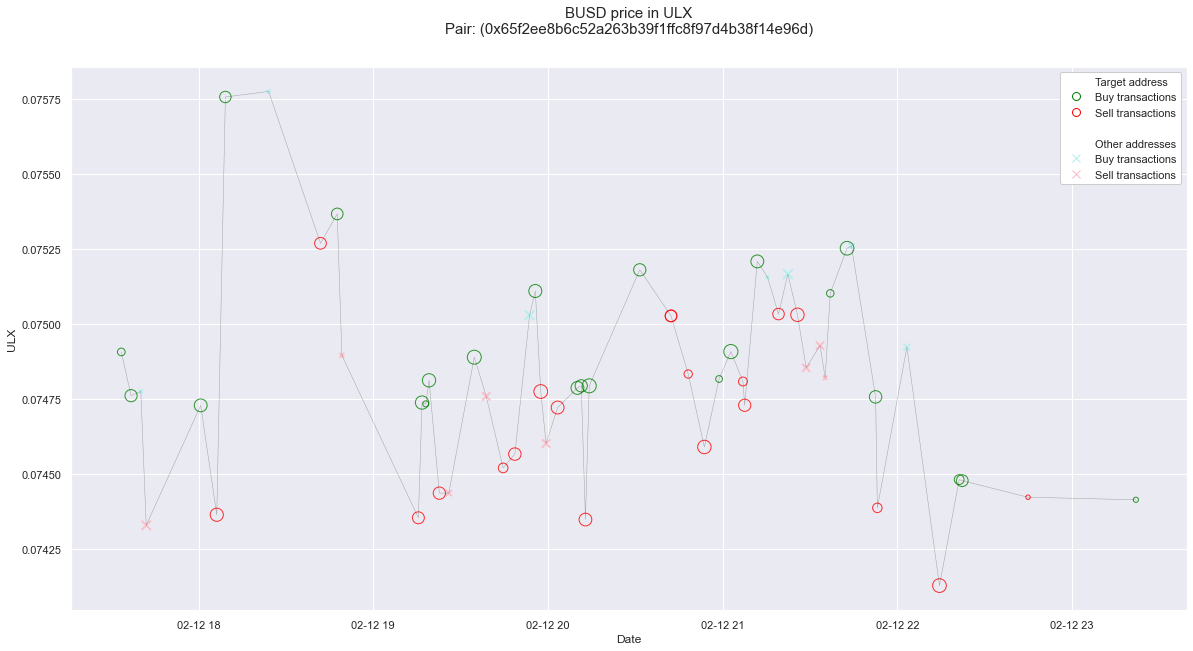

BUSD price in KAEW
The shape of wash traded transactions' dataframe: (63, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 0.9022644639179346
The number of accounts that commited wash trading: 5


,Wash Traders
0,0x0cb1920bae950a43af854f644a65b739201f1590
1,0x44e6027fc9aae41bd7dd0dc27438db9cd93c5372
2,0x685bfc18c63ef36f731d6d3a47ee778f08134b1e
3,0x9646d7883f2e63fddebdf2bd84f4cd0f31cb16de
4,0x9910bded839bd89e3961d1fc8241d91daaac6176


https://bscscan.com/address/0xcc7155fd9c385a912d8f939f84a3ed6b9e1674f2#tokentxns


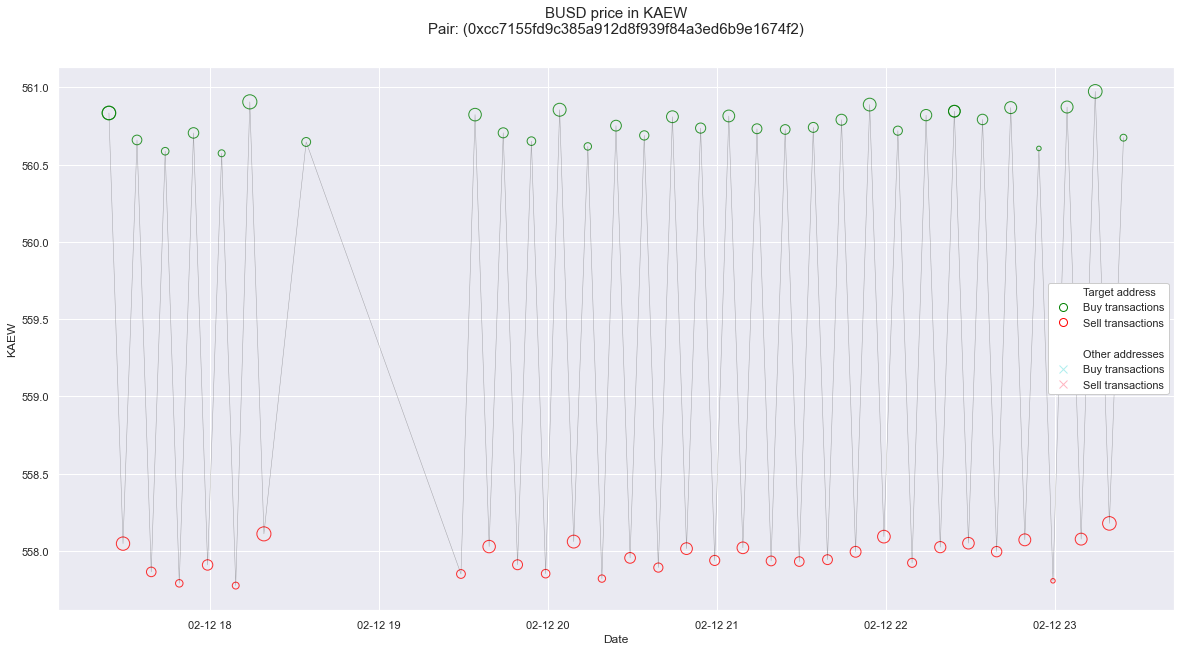

BUSD price in HAI
The shape of wash traded transactions' dataframe: (24, 22).
The shape of other transactions' dataframe: (64, 22).
The percentage of volume traded in this specific pair contract address: 6.49 %
The position ratio: 0.8487552520692958
The number of accounts that commited wash trading: 1


,Wash Traders
0,0xf52ebea7b851e452ece018fbd753bd6cb5387e36


https://bscscan.com/address/0x933f1b774b81ef9574ff808a5db8175d4d26688c#tokentxns


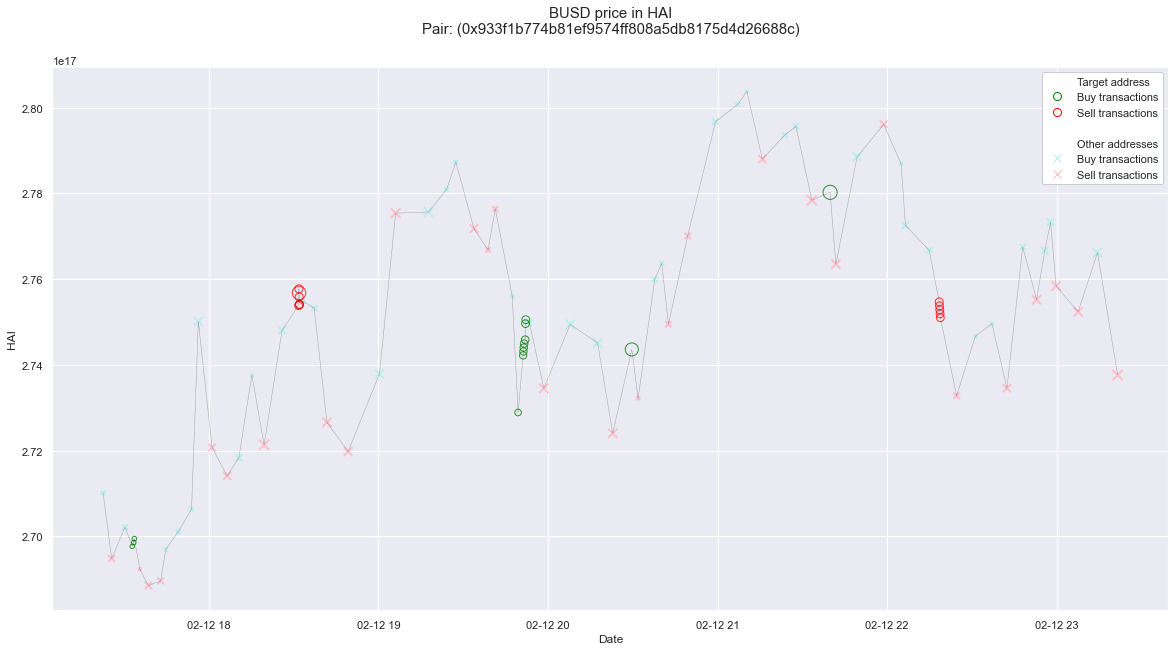

WBNB price in 2023MOON
The shape of wash traded transactions' dataframe: (418, 22).
The shape of other transactions' dataframe: (18, 22).
The percentage of volume traded in this specific pair contract address: 76.28 %
The position ratio: 0.9680060043196559
The number of accounts that commited wash trading: 1


,Wash Traders
0,0x10cad6c7f2c562b29ef6ec7262c3d89ec7d2dbb6


https://bscscan.com/address/0x304491098c9d146f1beb1ee64c77334ddf41a056#tokentxns


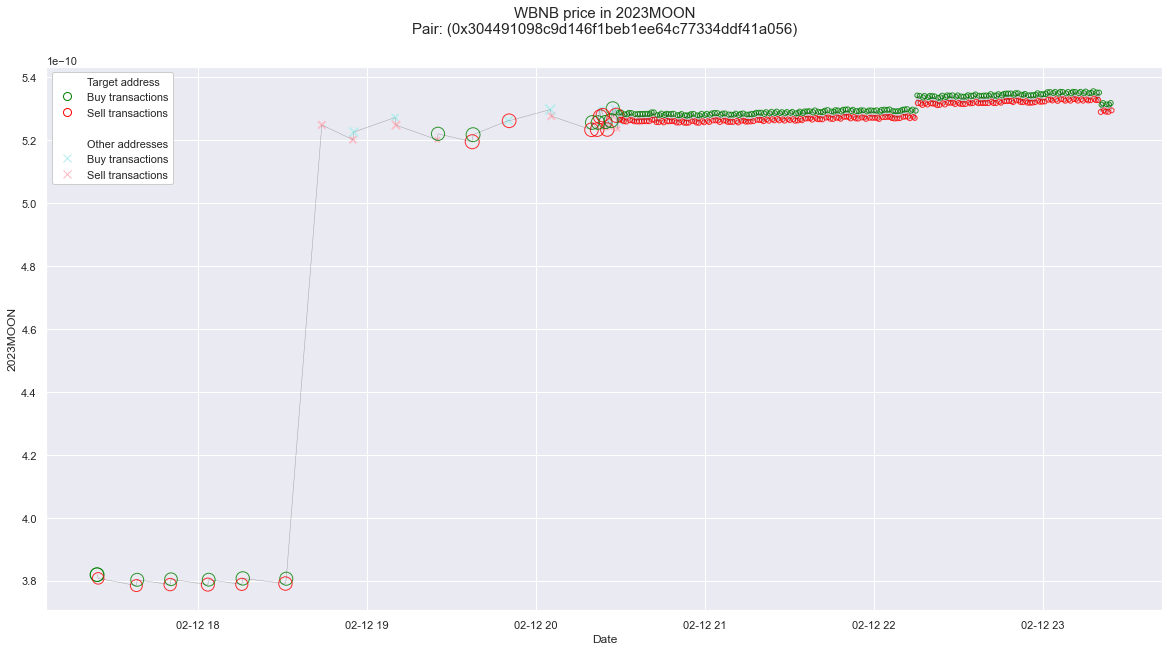

BUSD price in ARKFI
The shape of wash traded transactions' dataframe: (295, 22).
The shape of other transactions' dataframe: (9, 22).
The percentage of volume traded in this specific pair contract address: 64.48 %
The position ratio: 0.9127390865091037
The number of accounts that commited wash trading: 1


,Wash Traders
0,0x55553531d05394750d60efab7e93d73a356f5555


https://bscscan.com/address/0x4004d3856499d947564521511dcd28e1155c460b#tokentxns


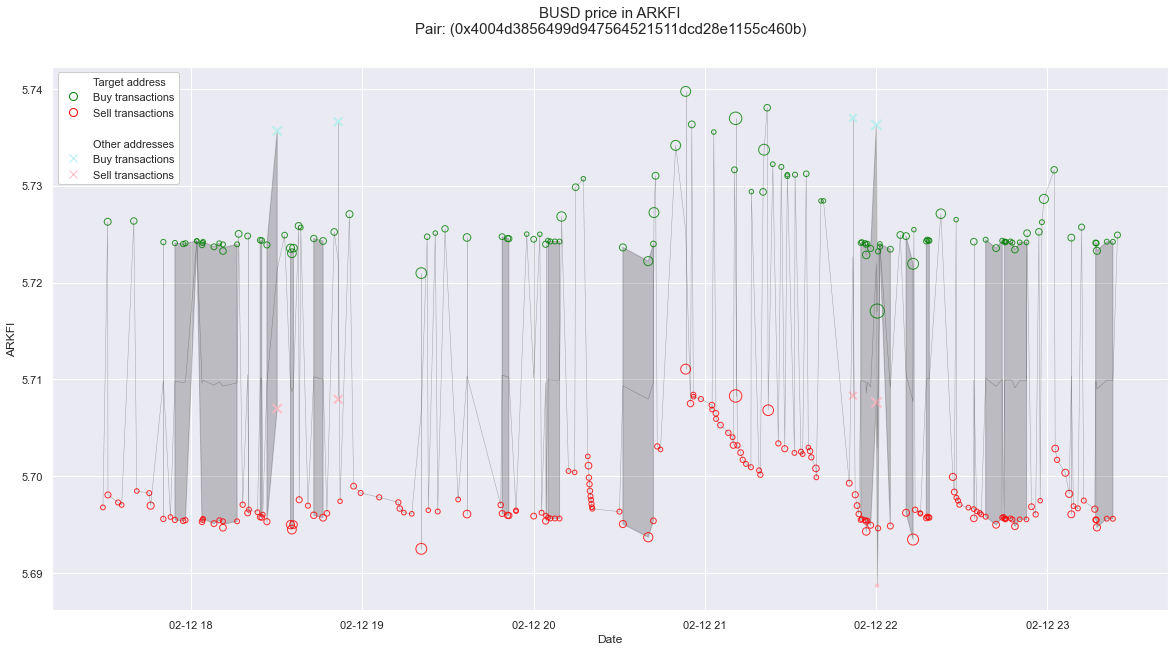

BUSD price in KZEN
The shape of wash traded transactions' dataframe: (52, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 0.8968060923341736
The number of accounts that commited wash trading: 7


,Wash Traders
0,0x5a0b66cea78384afa3638ac901abc599372e5a83
1,0x766cbc20074bc20651a9240e18081dd14d58dfff
2,0x9363204a32a3810db8aef41a85b6ce8e7470c6fb
3,0xa1b4ca42883874e1c24fb91ce5264bd8c901474e
4,0xe74bf332b8b155395ee9bcbf9050b6c0d6f0c297
5,0xf3bf580cf68d135e09481835a9d1002782d0027a
6,0xf4c2086c084f44ff045c2e1d4d1e0fbf2077d4ce


https://bscscan.com/address/0x34e5da4b256ded54731b1a8cfaa02b44c41a211d#tokentxns


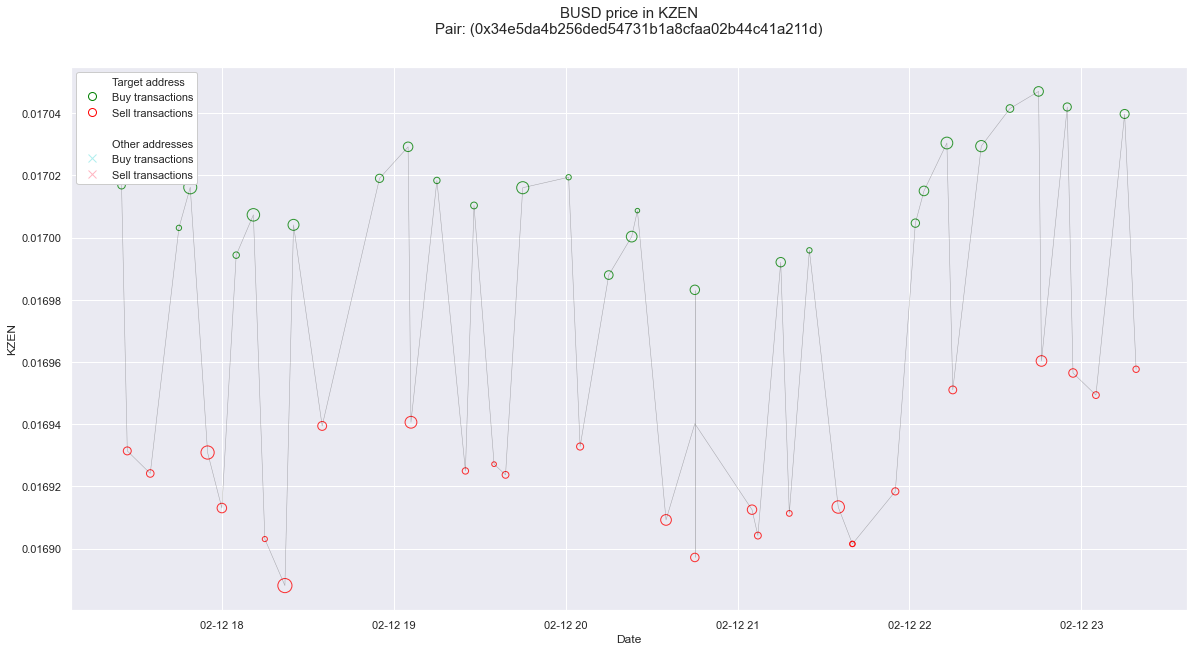

BUSD price in GINOA
The shape of wash traded transactions' dataframe: (66, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 1.001936874897662
The number of accounts that commited wash trading: 1


,Wash Traders
0,0x73b99ae712fbcec80b71e5bd532dd8bc32ebe5f0


https://bscscan.com/address/0xd8f6c9da8134282fa161a3927864202e06ddb614#tokentxns


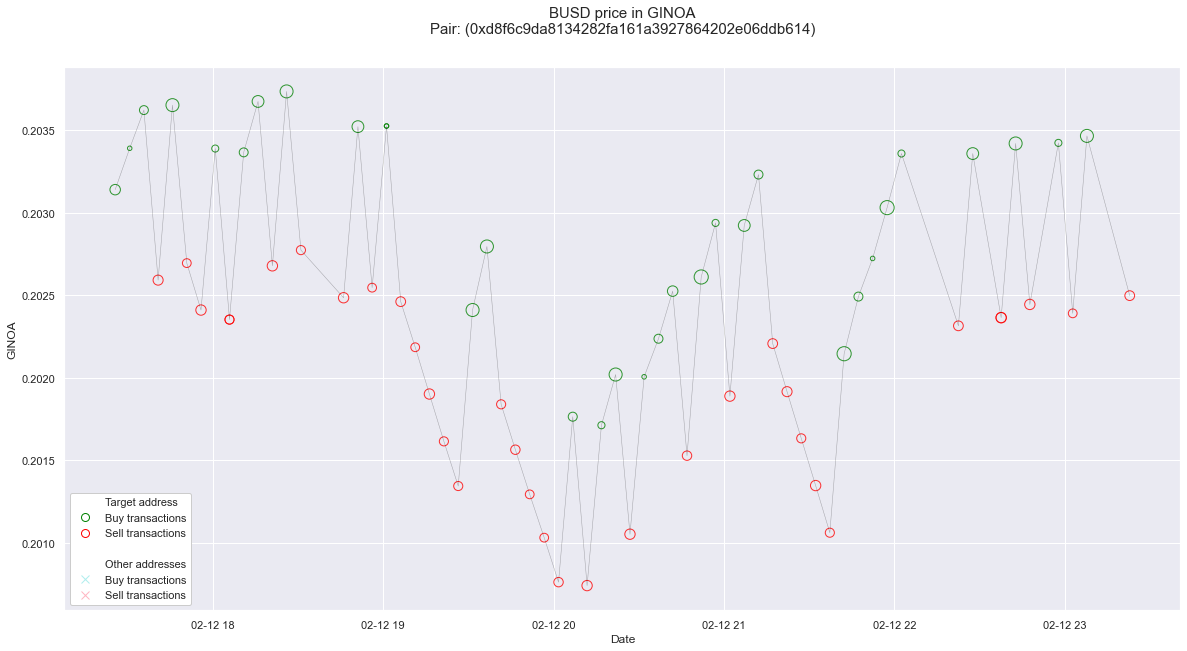

LAND price in USDT
The shape of wash traded transactions' dataframe: (69, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 1.0990820915311916
The number of accounts that commited wash trading: 2


,Wash Traders
0,0x875098dbca35899fb3e5e03be6d3cf041ab527b9
1,0xcc9c5bd0717a8489375ff24472d5c98a2520af7d


https://bscscan.com/address/0xb8e2776b5a2bced93692f118f2afc525732075fb#tokentxns


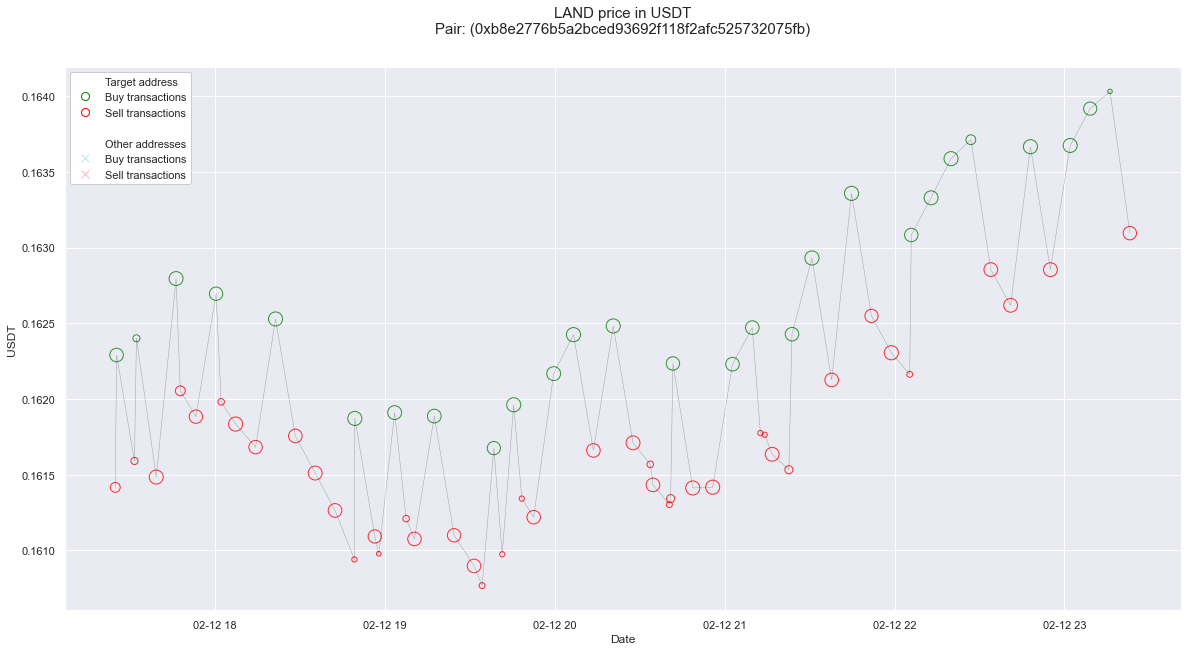

ARENA price in Cake
The shape of wash traded transactions' dataframe: (264, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 1.018665047806328
The number of accounts that commited wash trading: 3


,Wash Traders
0,0x941ad963f4faefee2376a55ce90933dd31881e6f
1,0xd4c4a7c55c9f7b3c48bafb6e8643ba79f42418df
2,0xe08b52571d7d1a535dd7d2d7115742504492a567


https://bscscan.com/address/0xfcc860289819c8b754ef31a1709a7952eb940223#tokentxns


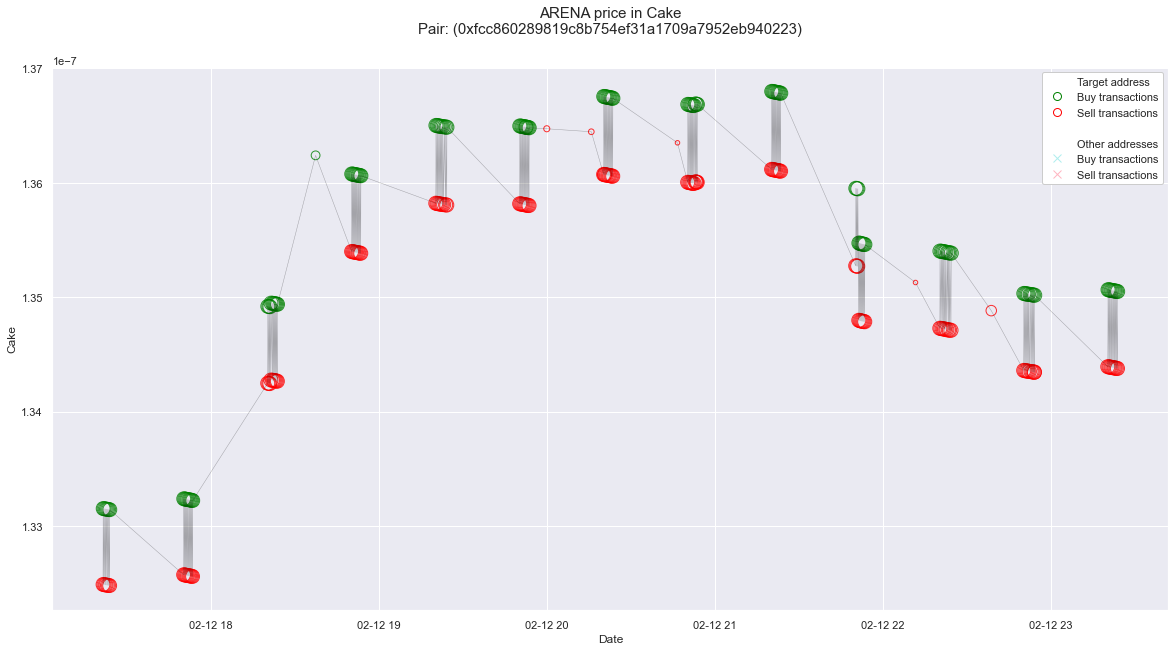

ZEDXION price in WBNB
The shape of wash traded transactions' dataframe: (64, 22).
The shape of other transactions' dataframe: (0, 22).
The percentage of volume traded in this specific pair contract address: 100.00 %
The position ratio: 0.867438749315032
The number of accounts that commited wash trading: 1


,Wash Traders
0,0xe35f9b331b93628373a85232fb9905cdffad9de6


https://bscscan.com/address/0xd26c77880a371ff6d683e9716a7b684232927987#tokentxns


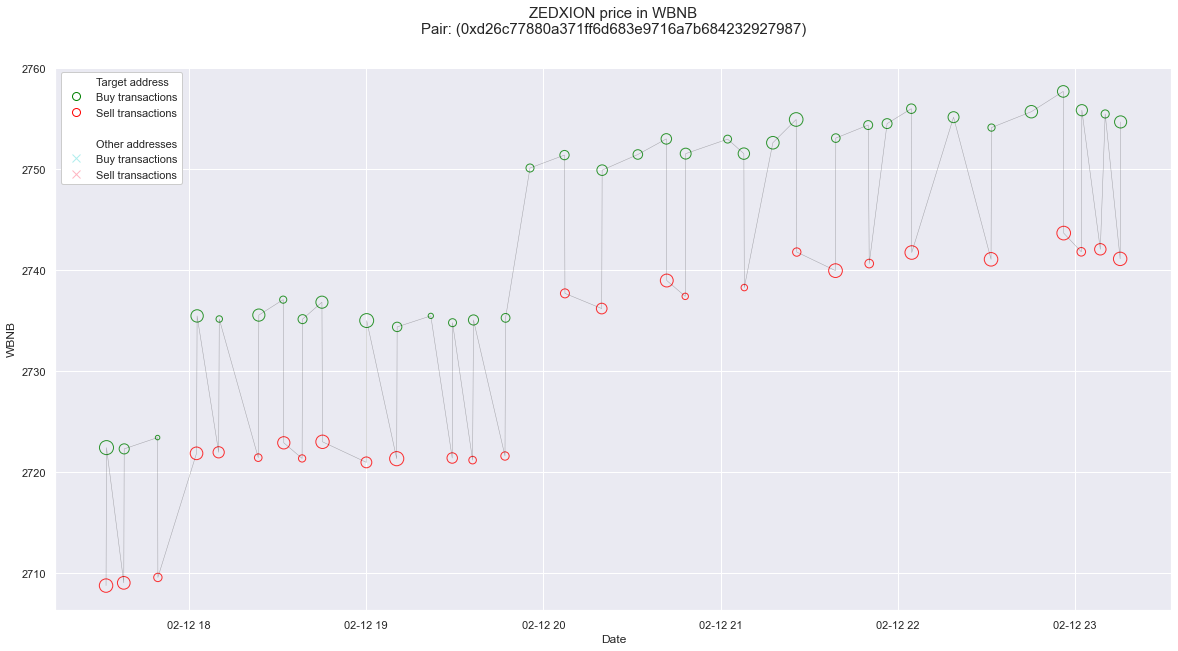

The total volume wash traded on Pancake Swap in the period of 6 hours: 1.993313118434791e-11 %


In [22]:
pair_contracts = df.contract_address.unique()
print(f"The number of unique pair contract addresses that were active during the {scrape_last_hours} hour window: {len(pair_contracts)}", end = "\n")

d = {}

for pair in pair_contracts:
    _df = df[df.contract_address == pair] # get all the transactions of the specific pair

    # to make sure that our sample is big enough for z-score statistic, 
    # we choose pair contract addresses that had more than 40 transactions for highest accuracy
    if _df.shape[0] < 50:
        continue
    

    token0_price_in_token1 = pd.to_numeric((_df.amount1In + _df.amount1Out) / (_df.amount0In + _df.amount0Out)) * (10 ** (pair_info["token0_decimals"] - pair_info["token1_decimals"]))
    # accounting for token decimals shown in contract
    _df["token0_price_in_token1"] = token0_price_in_token1
    token1_price_in_token0 = 1 / token0_price_in_token1
    _df["token1_price_in_token0"] = token1_price_in_token0

    pair_info = get_pair_info(pair, abi, bsc_scan_api_key, w3)
    pair_info["signatures"] = signatures

    _df["swap_size"] = pd.to_numeric((_df.amount1In + _df.amount1Out + _df.amount0In + _df.amount0Out)) # calculating swap size

    _df["is_buying"] = pd.to_numeric((_df.amount1In + _df.amount0Out)) > pd.to_numeric((_df.amount0In + _df.amount1Out)) # checking if the transaction is a buy or sell

    most_active_address = _df.groupby('To')['transactionHash'].count().sort_values(ascending = False, kind = 'mergesort')

    if most_active_address.iloc[0] == 1:
        continue
    most_active_address = most_active_address.index[0] # chosen the most active account in the dataset of specific pair contract address

    target_tx = _df[_df.To == most_active_address] # all the transactions associated with the most active address
    other_tx = _df[~(_df.To == most_active_address)] # all other transactions

    t_mean = target_tx['swap_size'].mean() # target transactions' mean of the swap size
    t_std = target_tx['swap_size'].std() # target transactions' standard deviation of the swap size

    wash_trading_data = _df[(_df['swap_size'] - t_mean) / t_std <= 3] # all transactions that could be potentially wash traded
    other_data = _df[(_df['swap_size'] - t_mean) / t_std > 3] # other transactions that are not

    # position ratio is an important indicator for checking if the accounts are not changing the relative purchase position
    position_ratio = (wash_trading_data.amount0In.sum() + wash_trading_data.amount1Out.sum() + 1) / (wash_trading_data.amount1In.sum() + wash_trading_data.amount0Out.sum() + 1)

    total_volume = 0

    if position_ratio >= 0.8 and position_ratio <= 1.2: # the margin of 20 percent is chosen for the position ratio to be accepted as occurence of wash trading 

        volume = _df.amount0Out.sum() + _df.amount0In.sum() + _df.amount1Out.sum() + _df.amount1In.sum() # total volume
        wash_volume = wash_trading_data.amount0Out.sum() + wash_trading_data.amount0In.sum() + wash_trading_data.amount1Out.sum() + wash_trading_data.amount1In.sum()
        wash_traders = wash_trading_data.To.unique()
        # adding the key metrics into a dictionary
        d[f'images/{pair_info["token1_symbol"]} price in {pair_info["token0_symbol"]}'] = (wash_volume, volume, wash_traders)

        print(f'{pair_info["token1_symbol"]} price in {pair_info["token0_symbol"]}')
        print(f"The shape of wash traded transactions' dataframe: {wash_trading_data.shape}.\nThe shape of other transactions' dataframe: {other_data.shape}.\nThe position ratio of wash traded transactions: {position_ratio}.", end = "\r")
        print(f"The percentage of volume traded in this specific pair contract address: {'{:.2f}'.format(wash_volume / volume * 100)} %", end = "\n")

        total_volume += wash_volume #adding wash trading volume to the total wash trading volume variable

        print(f"The position ratio: {position_ratio}", end = "\n")
        print(f"The number of accounts that commited wash trading: {len(wash_traders)}", end = "\n")

        display(pd.DataFrame(wash_traders, columns = ["Wash Traders"]))

        print(f"https://bscscan.com/address/{pair}#tokentxns")

        plot_addresses(_df, wash_trading_data, other_data, pair_info) # plotting the pair contract address transactions with wash trading activity

total_percentage = total_volume / (total_token0_volume_by_all_addresses + total_token1_volume_by_all_addresses) * 100
print(f"The total volume wash traded on Pancake Swap in the period of {scrape_last_hours} hours: {total_percentage} %", end = "\n")
    